# A gentle introduction to Stable Diffusion: Part 1 (introduction)

Hello and welcome to this explainer for Stable Diffusion - specifically targeting a non-technical audience. This will be a quick rundown of how *Latent Diffusion Models* (LDMs) work, specifically focusing on Stable Diffusion v1.4, as it is probably the most intuitive to explain.

This explainer will be split into multiple parts - first, we will give a high level overview of the model cascade itself, then we'll go into each component of the cascade, and finally, we'll put the model cascade together at the end!

This is the first section out of 5: a high level explanation of the model cascade. The other sections are accessible [here]( https://research.qut.edu.au/genailab/projects/genai-explained)

1. Introduction to the architecture
2. CLIP Text embedder
3. Variational AutoEncoder
4. UNet denoiser
5. Conclusion - putting it all together



## Some (brief) history

Text-to-image models are a fairly recent endeavour in the history of machine learning and AI research. For decades prior, the inverse task (image-to-text) was a much bigger focus in machine learning research, examples of this being Optical Character Recognition (OCR) and image captioning. Text-to-image was a significantly harder challenge, with higher dimensionality and variance in the output data - essentially, it was a lot easier to get a computer to write, than it was to get a computer to draw.

The first attempt at a text-to-image model that created images from scratch (prior attempts relied on discrete collages of exsiting images) was alignDRAW in 2015. This model, developed at the University of Toronto by [Mansimov et. al.](https://arxiv.org/pdf/1511.02793), used a recurrent Variational AutoEncoder (which we will cover in this tutorial!) and an LSTM (an early language embedding model) to generate 32x32 resolution images. The images were both low resolution and not particularly detailed, but the outputs showed promising results in guiding image outputs based on text prompts.

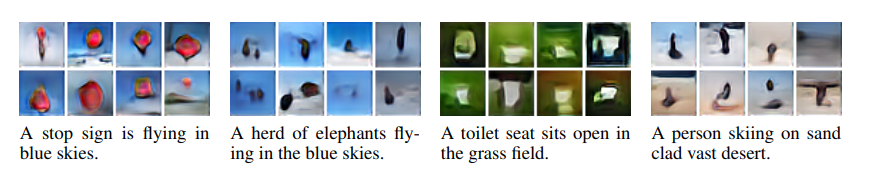

*alignDRAW examples*


Shortly after that, attempts were made to leverage Generative Adversarial Networks (GANs) for text-to-image tasks. The first attempt at this was a Conditional Generative Adversarial Network (CGAN) conditioned on free-text embeddings proposed by [Reed et al. in 2016](https://arxiv.org/pdf/1605.05396) (prior CGANs used a fixed set of class labels, rather than free-text). This added a conditional LSTM embedding to a GAN, and improved greatly upon output quality compared to alignDRAW. Research into this approach continued for another 6 or so years with significant improvements -  examples of this approach include [VQGAN-CLIP](https://arxiv.org/pdf/2204.08583) and [XMC-GAN](https://arxiv.org/pdf/2101.04702). Despite no longer being the current state-of-the-art, research into this approach of image generation still persists given several inherent advantages of GAN-based generation over Latent Diffusion Model-based generation.

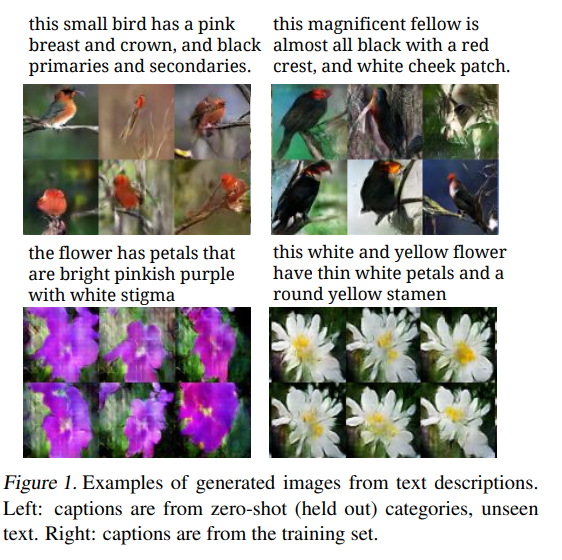 

*text-CGAN examples*

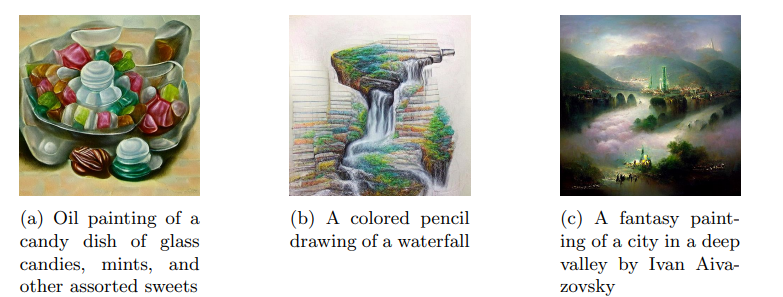

*VQGAN-CLIP examples*


However, what arose most recently as the state-of-the-art (SOTA) approach for text-to-image generation was Latent Diffusion Models (LDMs). Popularity of this approach skyrocketed in 2022 with the release of both [Stable Diffusion from Stability.AI](https://arxiv.org/pdf/2112.10752), and [Dall-E 2 from OpenAI](https://arxiv.org/pdf/2204.06125). These models not only increased the fidelity and realism of the output images over previous attempts, but also demonstrated far better adherence to the input text prompts. As of the creation of this explainer series (August 2024), this approach to text-to-image generation remains SOTA, but as with a lot of things in deep learning, there is every possibility it will be superceded!

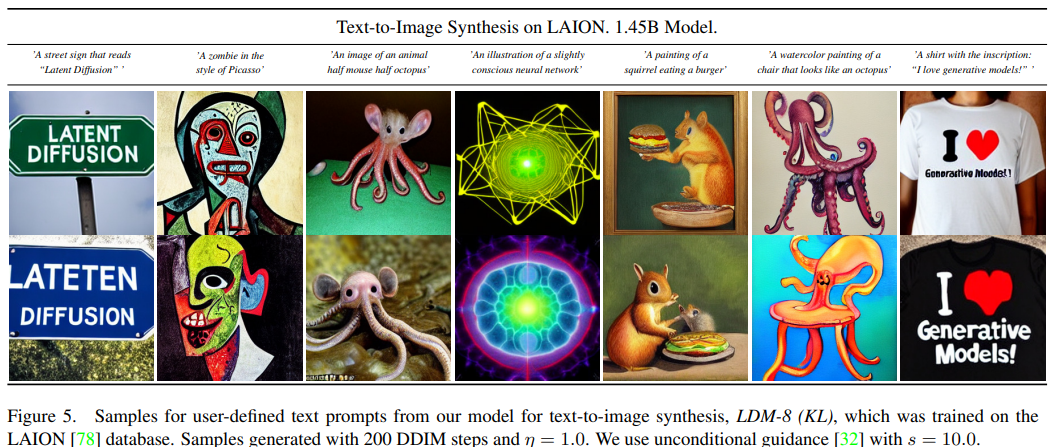

*Stable Diffusion Examples*

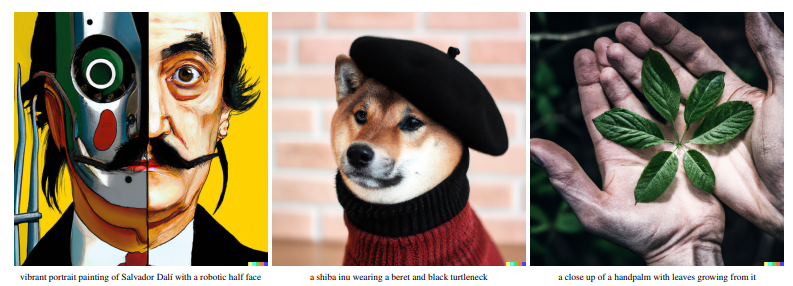

*Dall-E 2 examples*

## Some terminology

So what is a Latent Diffusion Model, anyway?

Well first let's define the terms *diffusion* and *latent*.


### Diffusion
*Diffusion* is actually a pretty generic concept that most of us would be familiar with, but in this case the meaning of the word diffusion might not be intuitive. 

Imagine an air freshener, or an essential oil diffuser. The scent comes in a liquid, but then gets *diffused* into the air - in more thermodynamic terms, the liquid's particles go from being in a more concentrated space (the inside of the air freshener) to a less concentrated, randomly distributed space (the room in which you are freshening air). Image data diffusion is the same concept - we can take an image and its data (the pixels), and *diffuse* their distribution (i.e. where there was structure to the colour of each pixel which would make up the image, the pixel colour values themselves distributed themselves into the most diffuse distribution possible, turning into completely random noise).

In essence (hah), the diffusion process on an image takes it from a recognisable image to completely randomly distributed noise, in the same way that an essential oil diffuser takes oil from a concentrated liquid to a set of dispersed particles in the air.


### Latent
*Latent* in general parlance means "hidden" or "dormant", and in the field of Machine/Deep Learning also means the same thing; a latent space is a hidden state within a model, which generally means a set of numbers that are supposed to represent information that is useful and descriptive to the model in some way, and can be used by it to generate something meaningful down the line. Usually, a latent space is also a lot smaller than an input as well - otherwise you may as well just preserve the input space! 

Typically then, **a latent space is used to compress/re-represent data, while preseving as much detail as possible**. A conceptually similar example of this in everyday life is a map - we could arguably navigate via satellite photos of the earth, but what we choose to use is abstracted, lower detail representations of the details we care about - paths, path-types, and in some cases topography/terrain type (could be see, grassy, concrete, etc.). So in a sense, you can think of a latent space as a specialised "map" of numbers, in lower detail than the original input, that the model can meaningfully use to infer information from the original data.

In the context of Latent Diffusion models, a latent space is used to compress an image into a much smaller size. At a super high level, you can think of it as taking a 512x512 resolution image and resizing it to 64x64 without losing a lot of quality, but we will go into more detail later on in this series. This is required to make the computer's job a lot easier when it comes to understanding the data it's being fed. Going back to our map example - imagine having to navigate with satellite images instead of maps!

---

Putting these words back together, we can then understand that Latent Diffusion Models **model the diffusion of latent space**. In our essential oil diffuser example, you can think of this model as understanding how the vapours of the essential oil *diffuse* into the air over time. Understanding this, we can then apply this to the latent representation of an image, where our model *learns how pixels will diffuse over time in a noising process*. The big thing to note here though, is that if you understand how a particular object, material, or data diffuses, *you should also be able to model how to reverse that process*, which is how latent diffusion models work to generate images - they will take completely random noise, and then from there, they will predict what the image is supposed to be, from the noise.

One practical thing to note - what researchers found in practice was that it was a lot more effective to add and subtract noise sequentially with a latent diffusion model to get a final image, and set the noise generation process to be a set of discrete timesteps, and so that's what we have today. LDMs start with a completely random 'noise' image, and then incrementally generate slightly more visually coherent images from that noise by denoising and then "renoising" with slightly less noise. Each time the image is denoised, the leftover image will have a little more detailed information in it than last time, and the image will be renoised a little bit less for the next loop around.

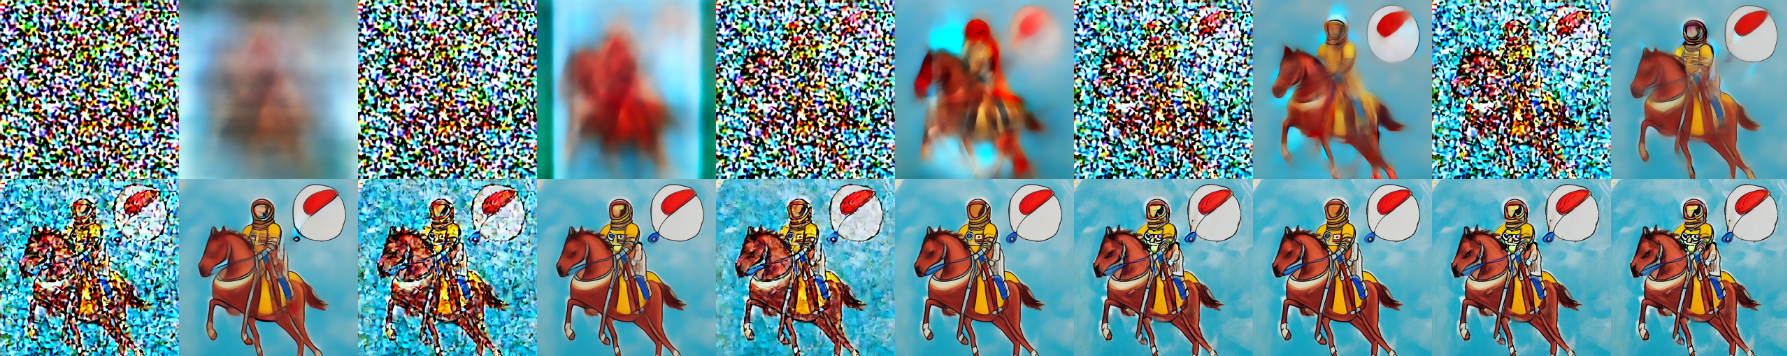

*the Stable Diffusion denoise+renoise loop over 10 steps*

Text-to-image models build on this approach by having augmenting the denoising model so that the denoising process can be "guided" by the text instructions, leaving behind specific details in the structure once the noise is removed.

In a sense, you can think of LDMs as sculptors more so than illustrators - they take a noisy block of raw stone, and carve out their image, rather than taking a blank canvas and painting an image from scratch.


## Part 1: intro to the architecture

### The model cascade

Latent Diffusion Models are actually a "cascade" of models.

What that means is that they are actually made up of several smaller models that work together to create one big model where one model's output feeds into another's input - sort of like a factory production line. For latent diffusion models, the high level logic of the model cascade is as follows:

1. **Text embedder:** this model takes the text prompt, and turns it into a series of numbers that the computer can understand, when are passed to the other models down the line.
   
2. **Image compressor:** this is a deep learning model which specialises in compressing data into a smaller size, while preserving as much information as possible. You can imagine this to be like an image compression algorithm like JPEG, but far more efficient at storing the certain kinds of data (specifically, the kinds of images that are used in the training process). This step is important as it allows the whole system to use much less computational power, because the compressed image representation is smaller than the raw image, so all of the other model cascade steps can also be smaller.

3. **Denoising model:** this is the core of the model - essentially, it takes the compressed image from step 2, and denoises it while leaving behind structure that resembels the text input.

This high-level logic broadly applies to all text-to-image models, including Dall-E and Imagen. What often differs is the models themselves, and how they might denoise, compress, or embed their data. The other thing worth noting is that this logic also generalises to other applications of generative AI: text-to-audio, text-to-video, even some text-to-text generation models! Hopefully then, this set of explainers will help you understand the high level logic behind a lot of generative AI models as well.

In the case of Stable Diffusion v1.4, the model cascade is as follows (don't worry if it's a little hard to follow at the moment - we'll go into each model in their own section):

1. [**Text Embedder: CLiP-ViT-L/14 -**](https://arxiv.org/pdf/2103.00020) This is an open-source text-embedder and image-embedder model, which was fine-tuned specifically for searching for images with text inputs. Essentially, if you type the word "dog" into a CLiP-powered search engine, this model will return a picture of a dog.

2. [**Image compressor: Variational Auto-Encoder (VAE) -**](https://arxiv.org/pdf/1906.02691) This model is specifically designed to take 512x512 resolution images, and compress them into 64x64 "images" without losing quality. Because of the size difference, you can think of this model as making images **64x** smaller, but without losing much visual quality.

3. [**Denoising model: UNet with Conditional Generation -**](https://sdxlturbo.ai/blog-The-UNet-actually-explained-in-10-minutes-19074) This model is a type of model called a 'UNet' (which comes from the shape of the model architecture - it looks like the letter 'U'!), with a few layers added in for "guidance" from the text embedding. Newer Stable Diffusion models use far more sophisticated architectures to denoise their compressed images, but this is probably the easiest to intuitively understand and explain!


With all of this explained, hopefully now, with some helpful additional labelling, we can intuit how the model is working in this diagram, published in their first [Stable Diffusion paper.](https://arxiv.org/pdf/2112.10752)

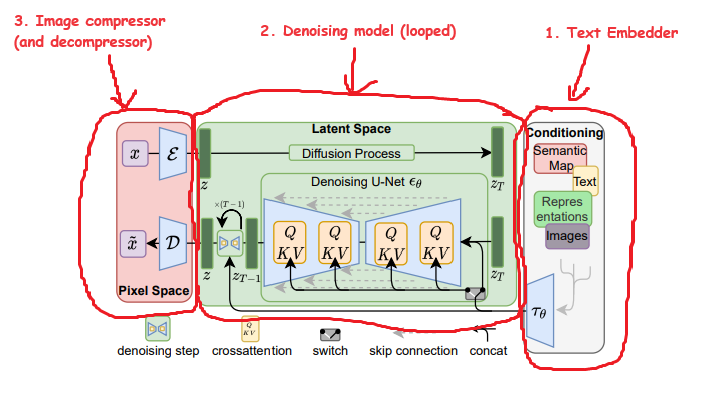

Now that we've done a high level overview, let's start with our first deep dive into one of the models - [the text embedder.]()